In [15]:
from sqlalchemy import create_engine, Column, String, Float, Integer, MetaData, Table
from sqlalchemy.orm import sessionmaker


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [18]:
import requests
import pandas as pd

base_url =f"https://world.openfoodfacts.org/api/v2/search?categories=chocolates&fields=code,product_name,brands,nutriments&page_size=100&page=1"


all_data = []
for page in range(1, 121):
    
    response = requests.get(base_url) 
    data = response.json()
    products = data.get("products", [])
    all_data.extend(products) # append results


print(f"Fetched page {page} → {len(products)} records (Total so far: {len(all_data)})")

Fetched page 120 → 100 records (Total so far: 12000)


In [48]:
df = pd.DataFrame(all_data)
df

,brands,code,nutriments,product_name
0,Sidi Ali,6111035000430,"{'carbohydrates': 42, 'carbohydrates_100g': 4....",Sidi Ali
1,Jaouda,6111242100992,"{'calcium': 0.25, 'calcium_100g': 0.25, 'calci...",Perly
2,sidi ali,6111035002175,"{'chloride': 0.014, 'chloride_100g': 0.014, 'c...",Sidi Ali
3,"Les Eaux Minérales d'oulmès,Sidi Ali",6111035000058,{'fruits-vegetables-legumes-estimate-from-ingr...,Eau minérale naturelle
4,AQUAFINA,6111252421568,"{'alcohol': 0, 'alcohol_100g': 0, 'alcohol_ser...",اكوافينا
...,...,...,...,...
11995,sos,6111251753912,"{'carbohydrates': 8.7, 'carbohydrates_100g': 8...",611251753912
11996,سلطان,6111248360130,"{'bicarbonate': 0.402, 'bicarbonate_100g': 0.4...",Aïn Soltane
11997,8dh,6111003031107,"{'carbohydrates': 0.6, 'carbohydrates_100g': 0...",
11998,Bjorg,3229820100234,"{'carbohydrates': 65, 'carbohydrates_100g': 65...",Fourrés Chocolat Noir


In [49]:
df.isnull().sum()

brands          0
code            0
nutriments      0
product_name    0
dtype: int64

In [50]:
# Count missing values per column
print("Missing values per column:\n", df.isnull().sum())

# Total missing values
print("\nTotal missing values in dataset:", df.isnull().sum().sum())


Missing values per column:
 brands          0
code            0
nutriments      0
product_name    0
dtype: int64

Total missing values in dataset: 0


In [51]:
#Clean 'brands' Column
# Remove extra spaces and lowercase all brands
df['brands'] = df['brands'].str.strip().str.lower()

# Replace empty strings or NaNs with 'unknown'
df['brands'] = df['brands'].replace('', 'unknown')
df['brands'] = df['brands'].fillna('unknown')

# Check unique brands after cleaning
print("Unique brands:", df['brands'].unique())
print("Total unique brands:", df['brands'].nunique())


Unique brands: ['sidi ali' 'jaouda' "les eaux minérales d'oulmès,sidi ali" 'aquafina'
 'cristaline' 'milky food professional' 'danone' 'ain atlas'
 'marmite,unilever' 'centrale danone' 'lilia' 'coca-cola' 'pepsi' 'lu'
 'lindt&sprüngli' 'lindt' "les eaux minérales d'oulmès s.a." 'ferrero'
 'coca cola' 'bimo' 'unknown' 'gerblé' 'délicia'
 "eau minérale naturelle des montagnes d'atlas" 'gullón'
 'eau minérale naturelle' 'star' 'jason’s' 'alpro' 'aïn saiss'
 'j.d. gross' "jason's" 'alesto,lidl' 'la hollandaise' 'cosumar'
 'alesto, 16 x lidl 10.25, lidl, lidl alesto, 14 x lidl 10.25' "henry's"
 'salim' 'the coca-cola company' 'ciel' 'maruja' 'original' 'lurpak'
 'bahia' 'oulmès' "green & black's" 'jibal' 'excelo' 'nestlé' 'aïn lfrane'
 'solis' 'heinz' 'aïn atlas' 'alesto,alesto lidl,alesto selection,lidl'
 'oatly' 'dost' 'la prairie' 'wasa' 'gervais' 'rigoni di asiago'
 'bonne maman' "tyrrell's" 'weetabix' 'green and black' 'volvic' 'joly'
 'primevère' 'sos' 'سلطان' '8dh' 'bjorg' 'el baraka

In [52]:
#Clean 'product_name' Column
# Strip spaces and fill missing with 'unknown'
df['product_name'] = df['product_name'].str.strip()
df['product_name'] = df['product_name'].replace('', 'unknown')
df['product_name'] = df['product_name'].fillna('unknown')


In [53]:
#Flatten dict/list columns (e.g., 'nutriments')
for col in df.columns:
    if df[col].apply(lambda x: isinstance(x, (dict, list))).any():
        print(f"Flattening column: {col}")
        expanded = pd.json_normalize(df[col])
        expanded.columns = [f"{col}_{sub}" for sub in expanded.columns]
        df = pd.concat([df.drop(columns=[col]), expanded], axis=1)


Flattening column: nutriments


In [54]:
#Handle NaN values for numeric columns
# Fill numeric columns with median
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())


In [55]:
#Handle NaN values for categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna('unknown')


In [56]:
#Remove Duplicates
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

df = df.drop_duplicates().reset_index(drop=True)


Number of duplicate rows: 11900


In [88]:
#Verify Cleaned Dataset
# Check missing values
print(df.isnull().sum())

# Quick peek at data
df.head()


brands                            0
code                              0
product_name                      0
nutriments_carbohydrates          0
nutriments_carbohydrates_100g     0
                                 ..
nutriments_omega-9-fat_label      0
nutriments_omega-9-fat_unit       0
nutriments_omega-9-fat_value      0
nutriments_proteins_modifier      0
calorie_category                 20
Length: 389, dtype: int64


,brands,code,product_name,nutriments_carbohydrates,nutriments_carbohydrates_100g,nutriments_carbohydrates_serving,nutriments_carbohydrates_unit,nutriments_carbohydrates_value,nutriments_energy,nutriments_energy-kcal,...,nutriments_omega-6-fat_label,nutriments_omega-6-fat_unit,nutriments_omega-6-fat_value,nutriments_omega-9-fat,nutriments_omega-9-fat_100g,nutriments_omega-9-fat_label,nutriments_omega-9-fat_unit,nutriments_omega-9-fat_value,nutriments_proteins_modifier,calorie_category
0,sidi ali,6111035000430,Sidi Ali,42.00,4.20,42.0,g,42.00,20.0,0.0,...,unknown,unknown,8.0,27.0,27.0,unknown,unknown,27.0,unknown,NaN
1,jaouda,6111242100992,Perly,9.40,9.40,9.4,g,9.40,406.0,97.0,...,unknown,unknown,8.0,27.0,27.0,unknown,unknown,27.0,unknown,0-100
2,sidi ali,6111035002175,Sidi Ali,6.75,6.75,5.3,unknown,6.75,487.0,116.0,...,unknown,unknown,8.0,27.0,27.0,unknown,unknown,27.0,unknown,101-200
3,"les eaux minérales d'oulmès,sidi ali",6111035000058,Eau minérale naturelle,6.75,6.75,5.3,unknown,6.75,487.0,116.0,...,unknown,unknown,8.0,27.0,27.0,unknown,unknown,27.0,unknown,101-200
4,aquafina,6111252421568,اكوافينا,0.00,0.00,0.0,g,0.00,0.0,0.0,...,unknown,unknown,8.0,27.0,27.0,unknown,unknown,27.0,unknown,NaN


In [89]:
df.columns

Index(['brands', 'code', 'product_name', 'nutriments_carbohydrates',
       'nutriments_carbohydrates_100g', 'nutriments_carbohydrates_serving',
       'nutriments_carbohydrates_unit', 'nutriments_carbohydrates_value',
       'nutriments_energy', 'nutriments_energy-kcal',
       ...
       'nutriments_omega-6-fat_label', 'nutriments_omega-6-fat_unit',
       'nutriments_omega-6-fat_value', 'nutriments_omega-9-fat',
       'nutriments_omega-9-fat_100g', 'nutriments_omega-9-fat_label',
       'nutriments_omega-9-fat_unit', 'nutriments_omega-9-fat_value',
       'nutriments_proteins_modifier', 'calorie_category'],
      dtype='object', length=389)

<Axes: xlabel='calorie_category', ylabel='count'>

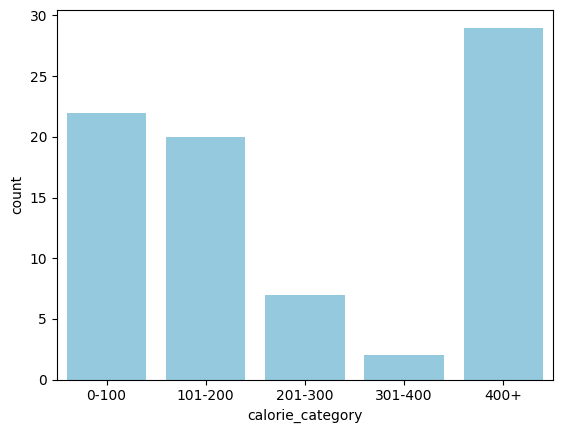

In [90]:
sns.countplot(
    data=df.dropna(subset=['calorie_category']), 
    x='calorie_category', 
    color='skyblue'  # replace palette with a single color
)

20


/var/folders/1d/bgyh7yvj5ggfr7rjr7vlckp40000gp/T/ipykernel_1069/2932283064.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df.dropna(subset=['calorie_category']), x='calorie_category', palette='Blues')


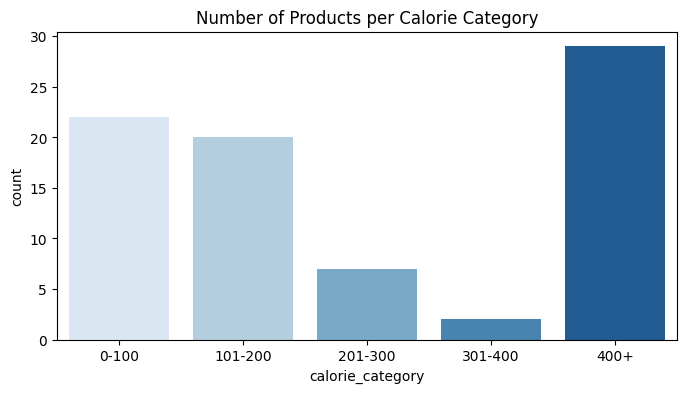

In [91]:

# Example: create calorie categories
df['calorie_category'] = pd.cut(
    df['nutriments_energy-kcal'],  # or 'nutriments_energy-kcal_value'
    bins=[0, 100, 200, 300, 400, 1000],
    labels=['0-100','101-200','201-300','301-400','400+']
)

# Optional: check for missing values
print(df['calorie_category'].isnull().sum())

# Plot
plt.figure(figsize=(8,4))
sns.countplot(data=df.dropna(subset=['calorie_category']), x='calorie_category', palette='Blues')
plt.title('Number of Products per Calorie Category')
plt.show()

In [125]:
import numpy as np

# 1️⃣ Sugar-to-Carb Ratio
df['sugar_to_carb_ratio'] = df['nutriments_sugars_100g'] / df['nutriments_carbohydrates_100g']
df['sugar_to_carb_ratio'] = df['sugar_to_carb_ratio'].replace([np.inf, -np.inf], 0).fillna(0)

# 2️⃣ Calorie Category
def calorie_category(kcal):
    if pd.isna(kcal):
        return 'Unknown'
    elif kcal < 150:
        return 'Low'
    elif kcal < 300:
        return 'Medium'
    else:
        return 'High'

df['calorie_category'] = df['nutriments_energy-kcal_100g'].apply(calorie_category)

# 3️⃣ Sugar Category
def sugar_category(sugar):
    if pd.isna(sugar):
        return 'Unknown'
    elif sugar < 5:
        return 'Low'
    elif sugar < 15:
        return 'Medium'
    else:
        return 'High'

df['sugar_category'] = df['nutriments_sugars_100g'].apply(sugar_category)

# 4️⃣ Ultra-processed Flag based on NOVA group
def ultra_processed(nova):
    if pd.isna(nova):
        return 'Unknown'
    elif nova >= 3:
        return 'Yes'
    else:
        return 'No'

df['is_ultra_processed'] = df['nutriments_nova-group'].apply(ultra_processed)

# Verify new columns
df[['sugar_to_carb_ratio', 'calorie_category', 'sugar_category', 'is_ultra_processed']].head()

,sugar_to_carb_ratio,calorie_category,sugar_category,is_ultra_processed
0,0.333333,Low,Low,Yes
1,0.138298,Low,Low,Yes
2,0.192593,Medium,Low,Yes
3,0.192593,Medium,Low,No
4,0.000000,Low,Low,Yes


In [123]:
#What this does:

#sugar_to_carb_ratio → shows proportion of sugar to total carbs

#calorie_category → Low / Medium / High based on kcal

#sugar_category → Low / Medium / High based on sugar content

#is_ultra_processed → Yes/No based on NOVA group

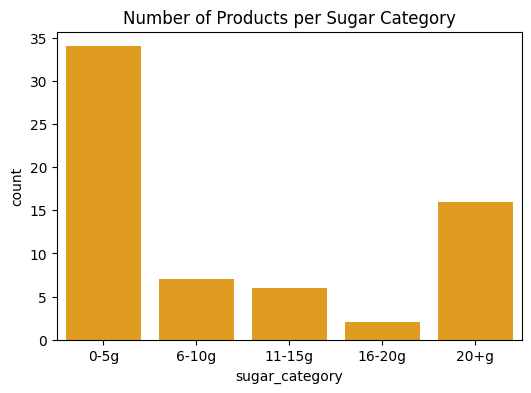

In [126]:
# Create sugar category column
df1['sugar_category'] = pd.cut(
    df1['nutriments_sugars_value'], 
    bins=[0, 5, 10, 15, 20, 100], 
    labels=['0-5g','6-10g','11-15g','16-20g','20+g']
)

# Plot
plt.figure(figsize=(6,4))
sns.countplot(data=df1.dropna(subset=['sugar_category']), x='sugar_category', color='orange')
plt.title('Number of Products per Sugar Category')
plt.show()

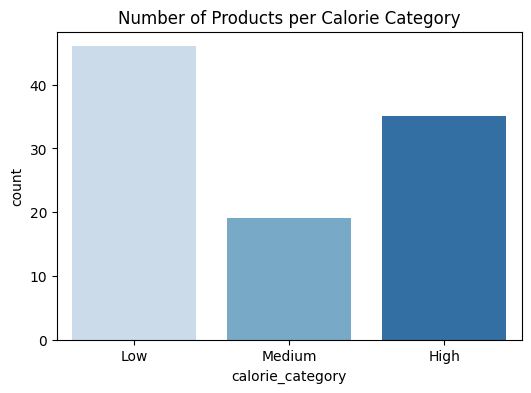

In [127]:
#Bar Charts for Calorie and Sugar Categories
# Calorie Category Count
plt.figure(figsize=(6,4))
sns.countplot(
    data=df,
    x='calorie_category',
    hue='calorie_category',  # assign x to hue
    palette='Blues',
    legend=False            # removes redundant legend
)
plt.title('Number of Products per Calorie Category')
plt.show()



Index(['brands', 'code', 'product_name', 'nutriments_carbohydrates',
       'nutriments_carbohydrates_100g', 'nutriments_carbohydrates_serving',
       'nutriments_carbohydrates_unit', 'nutriments_carbohydrates_value',
       'nutriments_energy', 'nutriments_energy-kcal',
       ...
       'nutriments_omega-9-fat', 'nutriments_omega-9-fat_100g',
       'nutriments_omega-9-fat_label', 'nutriments_omega-9-fat_unit',
       'nutriments_omega-9-fat_value', 'nutriments_proteins_modifier',
       'sugar_to_carb_ratio', 'calorie_category', 'sugar_category',
       'is_ultra_processed'],
      dtype='object', length=388)


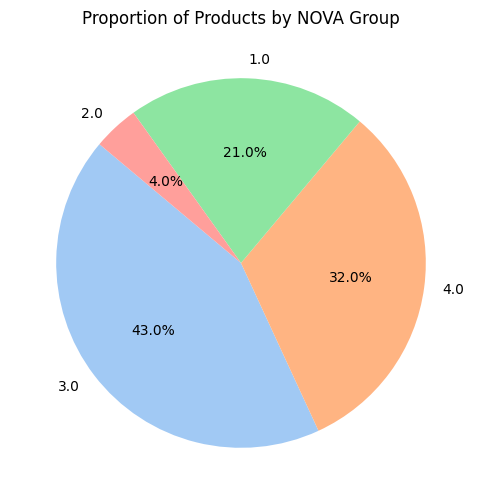

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check column names
print(df.columns)  # make sure the NOVA group column exists

# Use the correct column name
nova_counts = df['nutriments_nova-group'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    nova_counts, 
    labels=nova_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('pastel')
)
plt.title('Proportion of Products by NOVA Group')
plt.show()

In [116]:
print(df.columns.tolist())

['brands', 'code', 'product_name', 'nutriments_carbohydrates', 'nutriments_carbohydrates_100g', 'nutriments_carbohydrates_serving', 'nutriments_carbohydrates_unit', 'nutriments_carbohydrates_value', 'nutriments_energy', 'nutriments_energy-kcal', 'nutriments_energy-kcal_100g', 'nutriments_energy-kcal_serving', 'nutriments_energy-kcal_unit', 'nutriments_energy-kcal_value', 'nutriments_energy-kcal_value_computed', 'nutriments_energy-kj', 'nutriments_energy-kj_100g', 'nutriments_energy-kj_serving', 'nutriments_energy-kj_unit', 'nutriments_energy-kj_value', 'nutriments_energy-kj_value_computed', 'nutriments_energy_100g', 'nutriments_energy_serving', 'nutriments_energy_unit', 'nutriments_energy_value', 'nutriments_fat', 'nutriments_fat_100g', 'nutriments_fat_serving', 'nutriments_fat_unit', 'nutriments_fat_value', 'nutriments_fiber', 'nutriments_fiber_100g', 'nutriments_fiber_serving', 'nutriments_fiber_unit', 'nutriments_fiber_value', 'nutriments_fruits-vegetables-legumes-estimate-from-ingr

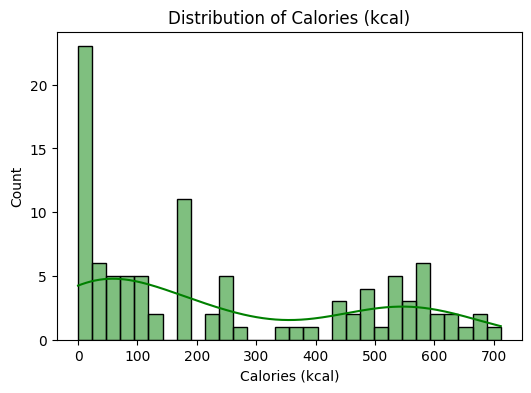

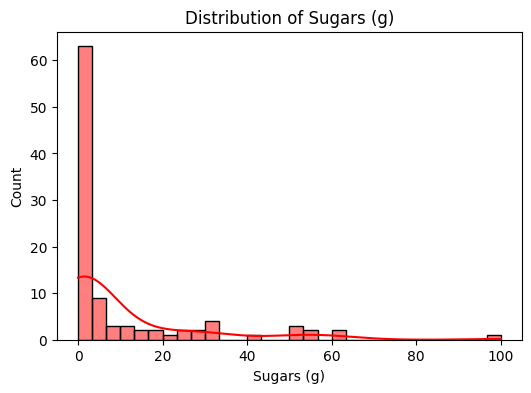

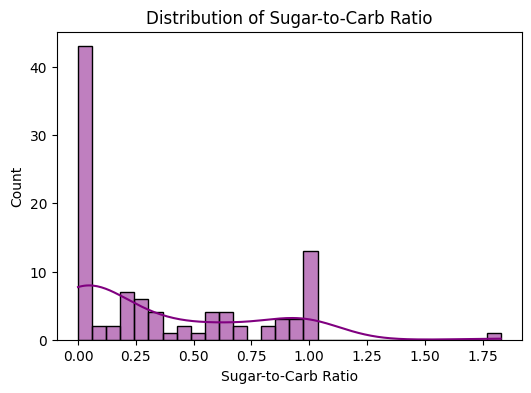

In [131]:

##Histograms for Calories, Sugars, Sugar-to-Carb Ratio
# Distribution of Calories (kcal)
plt.figure(figsize=(6,4))
sns.histplot(df['nutriments_energy-kcal_100g'], bins=30, kde=True, color='green')
plt.title('Distribution of Calories (kcal)')
plt.xlabel('Calories (kcal)')
plt.ylabel('Count')
plt.show()

# Distribution of Sugars (g)
plt.figure(figsize=(6,4))
sns.histplot(df['nutriments_sugars_100g'], bins=30, kde=True, color='red')
plt.title('Distribution of Sugars (g)')
plt.xlabel('Sugars (g)')
plt.ylabel('Count')
plt.show()

# Distribution of Sugar-to-Carb Ratio
plt.figure(figsize=(6,4))
sns.histplot(df['sugar_to_carb_ratio'], bins=30, kde=True, color='purple')
plt.title('Distribution of Sugar-to-Carb Ratio')
plt.xlabel('Sugar-to-Carb Ratio')
plt.ylabel('Count')
plt.show()

/var/folders/1d/bgyh7yvj5ggfr7rjr7vlckp40000gp/T/ipykernel_1069/1505186038.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='brands', y='nutriments_energy-kcal_value', data=df_top_brands, palette='Blues')


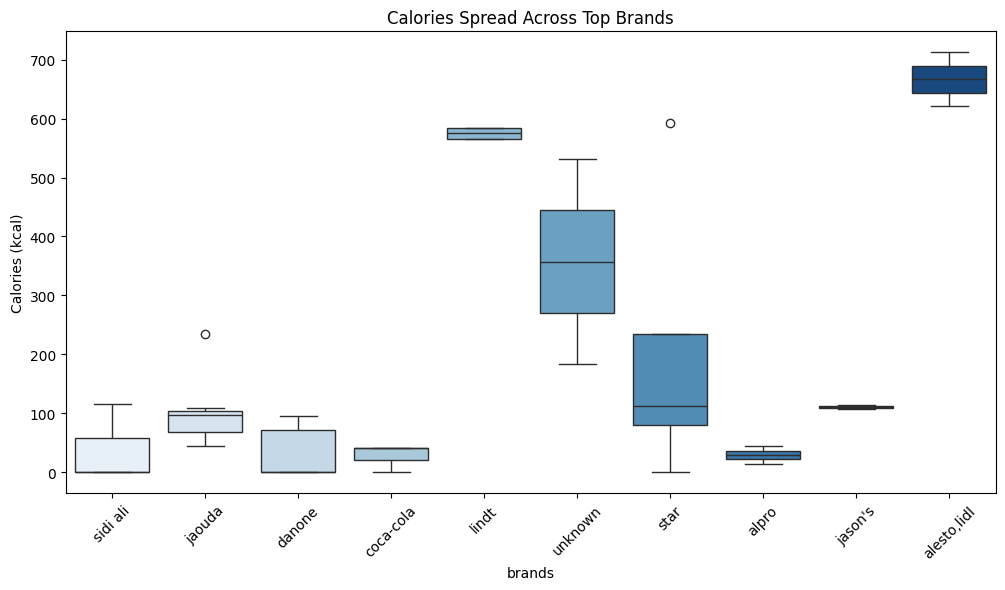

/var/folders/1d/bgyh7yvj5ggfr7rjr7vlckp40000gp/T/ipykernel_1069/1505186038.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='brands', y='nutriments_sugars_100g', data=df_top_brands, palette='Oranges')


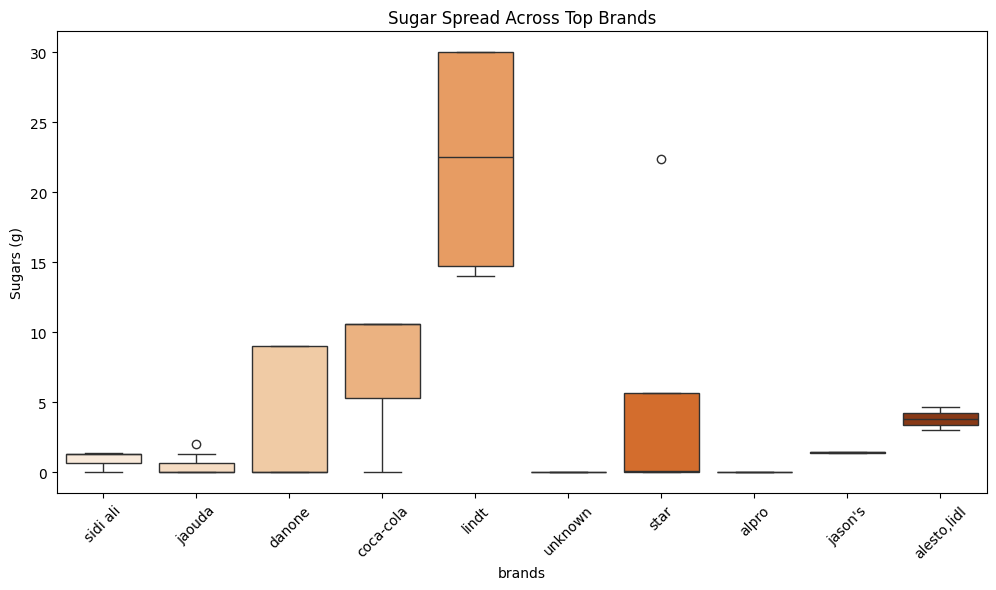

In [135]:
#Box Plots for Calories and Sugar Across Top Brands
# Top 10 brands by number of products
top_brands = df['brands'].value_counts().head(10).index
df_top_brands = df[df['brands'].isin(top_brands)]

plt.figure(figsize=(12,6))
sns.boxplot(x='brands', y='nutriments_energy-kcal_value', data=df_top_brands, palette='Blues')
plt.title('Calories Spread Across Top Brands')
plt.xticks(rotation=45)
plt.ylabel('Calories (kcal)')
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x='brands', y='nutriments_sugars_100g', data=df_top_brands, palette='Oranges')
plt.title('Sugar Spread Across Top Brands')
plt.xticks(rotation=45)
plt.ylabel('Sugars (g)')
plt.show()

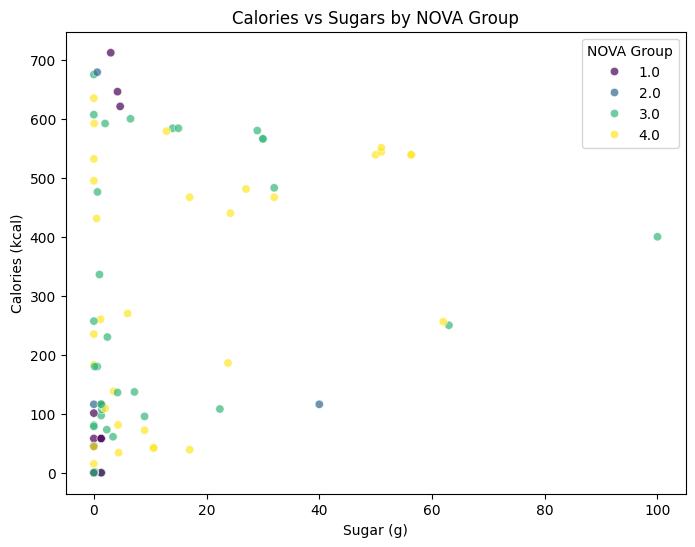

In [137]:
#Scatter Plot Calories vs Sugars
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='nutriments_sugars_100g',
    y='nutriments_energy-kcal_value',
    hue='nutriments_nova-group',
    palette='viridis',
    alpha=0.7
)
plt.title('Calories vs Sugars by NOVA Group')
plt.xlabel('Sugar (g)')
plt.ylabel('Calories (kcal)')
plt.legend(title='NOVA Group')
plt.show()

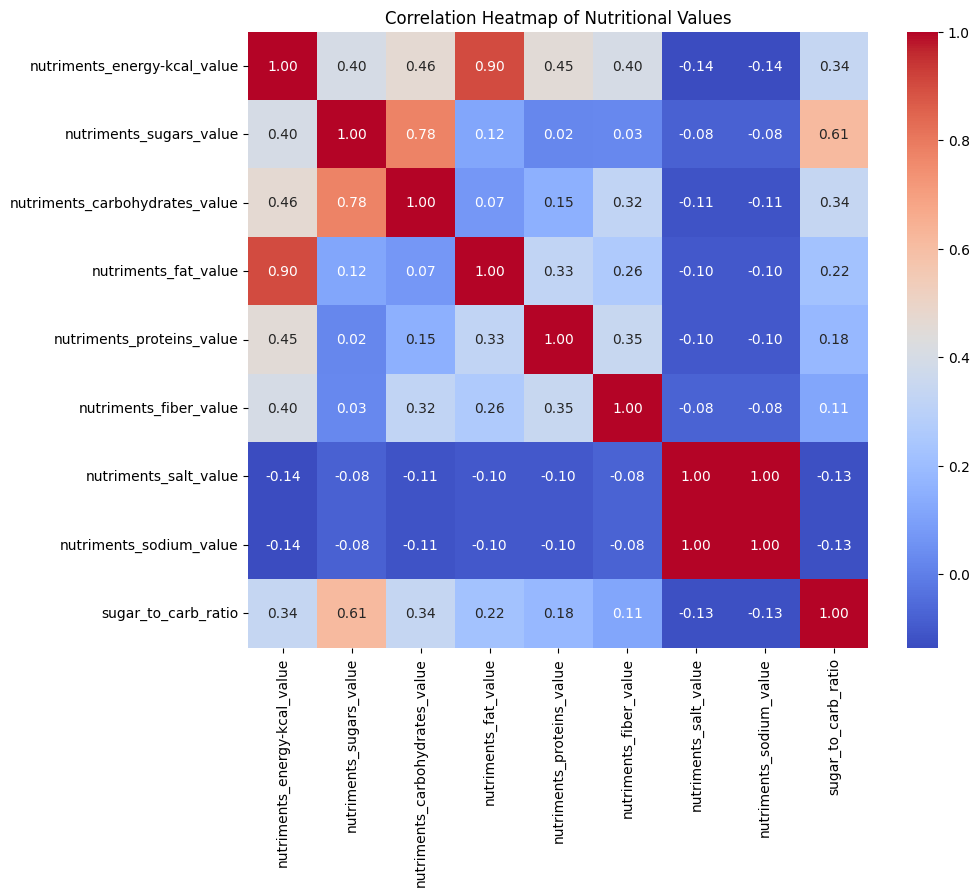

In [139]:
#Heatmap for Correlations
plt.figure(figsize=(10,8))

numeric_cols = [
    'nutriments_energy-kcal_value', 
    'nutriments_sugars_value', 
    'nutriments_carbohydrates_value', 
    'nutriments_fat_value', 
    'nutriments_proteins_value', 
    'nutriments_fiber_value', 
    'nutriments_salt_value', 
    'nutriments_sodium_value', 
    'sugar_to_carb_ratio'
]

corr_matrix = df[numeric_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Nutritional Values')
plt.show()

/var/folders/1d/bgyh7yvj5ggfr7rjr7vlckp40000gp/T/ipykernel_1069/2113050665.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_calories.index, y=top_calories.values, palette='Reds_r')


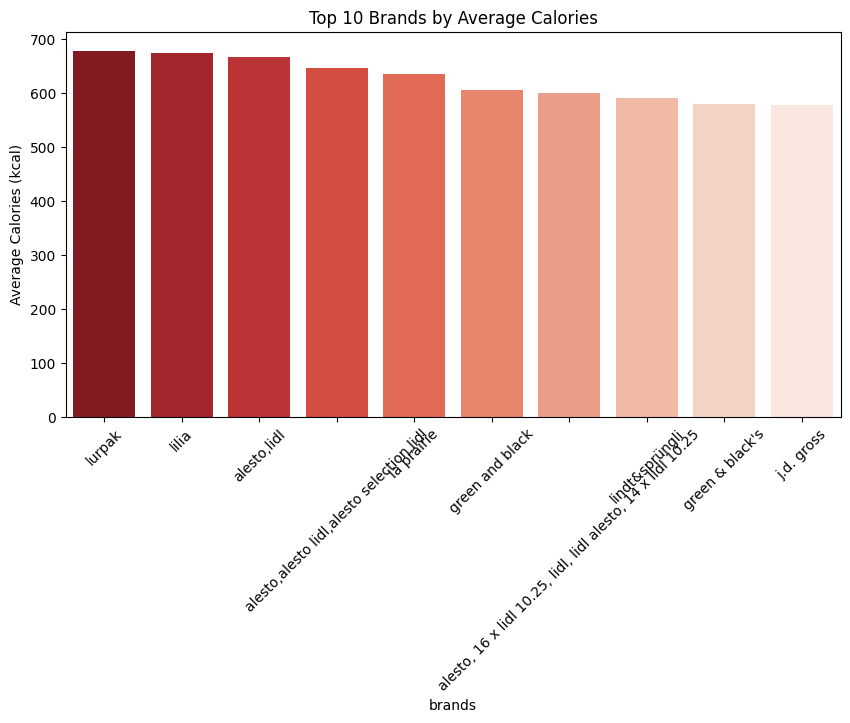

/var/folders/1d/bgyh7yvj5ggfr7rjr7vlckp40000gp/T/ipykernel_1069/2113050665.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sugars.index, y=top_sugars.values, palette='Oranges_r')


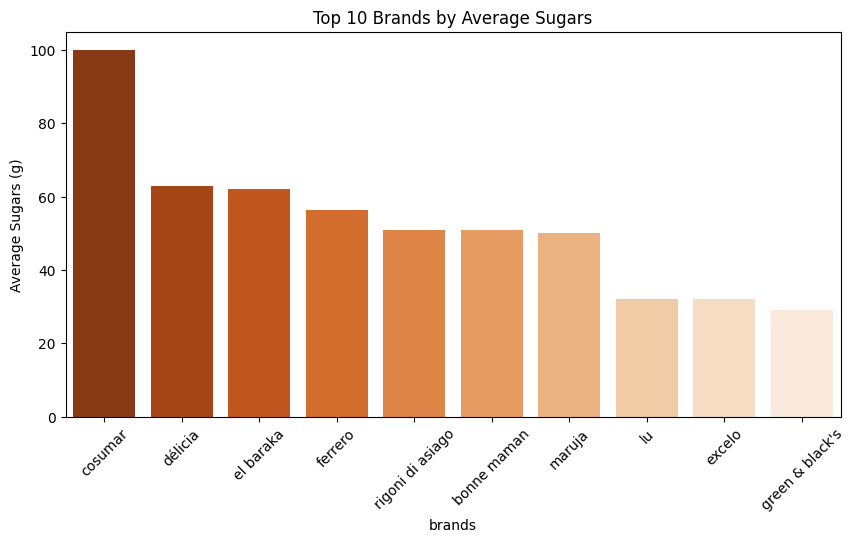

In [141]:
#Top N Brands by Average Calories or Sugars
# Top 10 brands by average calories
# Top 10 brands by average calories
top_calories = df.groupby('brands')['nutriments_energy-kcal_value'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_calories.index, y=top_calories.values, palette='Reds_r')
plt.title('Top 10 Brands by Average Calories')
plt.xticks(rotation=45)
plt.ylabel('Average Calories (kcal)')
plt.show()

# Top 10 brands by average sugars
top_sugars = df.groupby('brands')['nutriments_sugars_value'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_sugars.index, y=top_sugars.values, palette='Oranges_r')
plt.title('Top 10 Brands by Average Sugars')
plt.xticks(rotation=45)
plt.ylabel('Average Sugars (g)')
plt.show()


In [150]:
#Prepare Features and Targets
# Features: use numeric columns
# Features
X = df[['nutriments_sugars_value', 
        'nutriments_carbohydrates_value', 
        'nutriments_fat_value', 
        'nutriments_proteins_value', 
        'nutriments_fiber_value', 
        'nutriments_salt_value', 
        'nutriments_sodium_value', 
        'sugar_to_carb_ratio']]

# Regression target
y_reg = df['nutriments_energy-kcal_value']

In [159]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Ensure predictions and targets are numeric arrays
y_test_reg = np.array(y_test_reg, dtype=np.float64).ravel()
y_pred_reg = np.array(y_pred_reg, dtype=np.float64).ravel()

# Remove NaN or infinite values
mask = ~np.isnan(y_test_reg) & ~np.isnan(y_pred_reg) & ~np.isinf(y_test_reg) & ~np.isinf(y_pred_reg)
y_test_reg = y_test_reg[mask]
y_pred_reg = y_pred_reg[mask]

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

print("RMSE:", rmse)
print("R^2 Score:", r2)

RMSE: 42.64217510184263
R^2 Score: 0.9712406661168592


In [164]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Features
numeric_cols = [
    'nutriments_sugars_value',
    'nutriments_carbohydrates_value',
    'nutriments_fat_value',
    'nutriments_proteins_value',
    'nutriments_fiber_value',
    'nutriments_salt_value',
    'nutriments_sodium_value',
    'sugar_to_carb_ratio'
]

X_clf = df[numeric_cols].fillna(0)  # handle missing values
y_clf = df['is_ultra_processed'].map({'Yes': 1, 'No': 0})

# Train-test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42
)

# Train classifier
clf_model = RandomForestClassifier(n_estimators=100, random_state=42)
clf_model.fit(X_train_clf, y_train_clf)

# Predict
y_pred_clf = clf_model.predict(X_test_clf)

# Evaluate
print("Accuracy:", accuracy_score(y_test_clf, y_pred_clf))
print(classification_report(y_test_clf, y_pred_clf))

Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.93      0.87      0.90        15

    accuracy                           0.85        20
   macro avg       0.80      0.83      0.81        20
weighted avg       0.86      0.85      0.85        20



In [224]:
# Assuming X_test and y_test are defined
r2 = model.score(X_test, y_test)
print("R² score:", r2)

R² score: 0.9712406661168592


In [225]:
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9712406661168592


In [ ]:
#What these cells do:
#Prepare features and targets

#Split into train/test sets

###Train Random Forest Regressor for calories

#Train Random Forest Classifier for calorie category

#Evaluate performance with RMSE, R², accuracy, classification report

#Show feature importance for regression

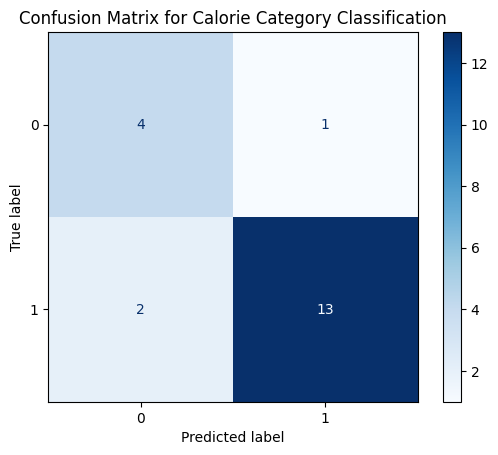

In [165]:
#Confusion Matrix for Classification Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
y_pred_clf = clf_model.predict(X_test_clf)

# Compute confusion matrix
cm = confusion_matrix(y_test_clf, y_pred_clf, labels=clf_model.classes_)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Calorie Category Classification')
plt.show()


In [166]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test_clf, y_pred_clf, labels=clf_model.classes_)

# For binary classification only
if cm.shape == (2,2):
    TN, FP, FN, TP = cm.ravel()
    print(f"True Positive (TP): {TP}")
    print(f"True Negative (TN): {TN}")
    print(f"False Positive (FP): {FP}")
    print(f"False Negative (FN): {FN}")
else:
    print("Multiclass classification: confusion matrix has more than 2 classes")
    print(cm)


True Positive (TP): 13
True Negative (TN): 4
False Positive (FP): 1
False Negative (FN): 2


In [167]:
from sklearn.metrics import confusion_matrix

# Classes
classes = clf_model.classes_

# Compute confusion matrix
cm = confusion_matrix(y_test_clf, y_pred_clf, labels=classes)

# Display overall confusion matrix
print("Confusion Matrix:\n", cm)

# Compute TP, TN, FP, FN per class
print("\nTP, TN, FP, FN for each class:")
for i, cls in enumerate(classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    print(f"\nClass: {cls}")
    print(f"True Positive (TP): {TP}")
    print(f"True Negative (TN): {TN}")
    print(f"False Positive (FP): {FP}")
    print(f"False Negative (FN): {FN}")


Confusion Matrix:
 [[ 4  1]
 [ 2 13]]

TP, TN, FP, FN for each class:

Class: 0
True Positive (TP): 4
True Negative (TN): 13
False Positive (FP): 2
False Negative (FN): 1

Class: 1
True Positive (TP): 13
True Negative (TN): 4
False Positive (FP): 1
False Negative (FN): 2


Classification Report:

              precision    recall  f1-score   support

        High       0.88      1.00      0.93         7
         Low       1.00      1.00      1.00         9
      Medium       1.00      0.75      0.86         4

    accuracy                           0.95        20
   macro avg       0.96      0.92      0.93        20
weighted avg       0.96      0.95      0.95        20



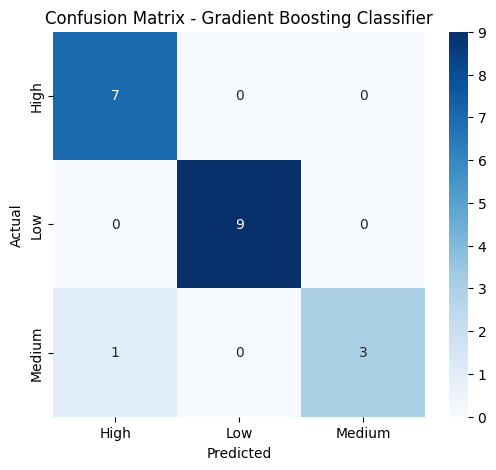

In [230]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Features (numerical nutrition features)
features = ["nutriments_carbohydrates_100g", "nutriments_sugars_100g", 
            "nutriments_fat_100g", "nutriments_proteins_100g", 
            "nutriments_fiber_100g", "nutriments_sodium_100g"]

X = df[features].fillna(0)
y = df["calorie_category"]

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Initialize Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Fit the model
gb_model.fit(X_train, y_train)

# Predictions
y_pred = gb_model.predict(X_test)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting Classifier')
plt.show()

In [231]:
train_accuracy = gb_model.score(X_train, y_train)
print(f"Train Accuracy: {train_accuracy:.2f}")

# Test accuracy
test_accuracy = gb_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Train Accuracy: 1.00
Test Accuracy: 0.95


In [172]:
from sqlalchemy import create_engine, MetaData, Table, Column, String, Float, Integer

# Create database engine
engine = create_engine('sqlite:///products.db')  # Replace with your DB URI if not SQLite

# Create a new MetaData object
metadata = MetaData()

# Table 1: product_info
product_info = Table(
    'product_info', metadata,
    Column('product_code', String, primary_key=True),
    Column('product_name', String),
    Column('brand', String)
)

# Table 2: nutrient_info
nutrient_info = Table(
    'nutrient_info', metadata,
    Column('product_code', String, primary_key=True),
    Column('energy_kcal_value', Float),
    Column('energy_kj_value', Float),
    Column('carbohydrates_value', Float),
    Column('sugars_value', Float),
    Column('fat_value', Float),
    Column('saturated_fat_value', Float),
    Column('proteins_value', Float),
    Column('fiber_value', Float),
    Column('salt_value', Float),
    Column('sodium_value', Float),
    Column('fruits_vegetables_nuts_100g', Float),
    Column('nutrition_score_fr', Integer),
    Column('nova_group', Integer)
)

# Table 3: derived_metrics
derived_metrics = Table(
    'derived_metrics', metadata,
    Column('product_code', String, primary_key=True),
    Column('sugar_to_carb_ratio', Float),
    Column('calorie_category', String),
    Column('sugar_category', String),
    Column('is_ultra_processed', String)
)

# Drop existing tables and create new ones
metadata.drop_all(engine)
metadata.create_all(engine)

print("Tables recreated successfully.")

Tables recreated successfully.


In [173]:

from sqlalchemy import delete

with engine.begin() as conn:
    conn.execute(delete(product_info))
    conn.execute(delete(nutrient_info))
    conn.execute(delete(derived_metrics))

print("✅ Old rows deleted from all tables")


✅ Old rows deleted from all tables


In [180]:
from sqlalchemy.dialects.sqlite import insert as sqlite_insert

with engine.begin() as conn:  # This automatically begins a transaction and commits at the end
    for _, row in df.iterrows():
        ins = sqlite_insert(product_info).values(
            product_code=row['code'],
            product_name=row['product_name'],
            brand=row['brands']
        ).prefix_with("OR IGNORE")  # Skip if duplicate
        conn.execute(ins)

In [181]:
with engine.connect() as conn:
    trans = conn.begin()
    try:
        for _, row in df.iterrows():
            ins = sqlite_insert(product_info).values(
                product_code=row['code'],
                product_name=row['product_name'],
                brand=row['brands']
            ).prefix_with("OR IGNORE")
            conn.execute(ins)
        trans.commit()
    except:
        trans.rollback()
        raise


In [184]:
from sqlalchemy.dialects.sqlite import insert as sqlite_insert

# Insert into product_info (skip duplicates using OR IGNORE)
with engine.begin() as conn:  # engine.begin() handles commit/rollback automatically
    for _, row in df.iterrows():
        ins = sqlite_insert(product_info).values(
            product_code=row['code'],
            product_name=row['product_name'],
            brand=row['brands']
        ).prefix_with("OR IGNORE")  # skip if duplicate
        conn.execute(ins)

# Insert into nutrient_info (skip duplicates)
with engine.begin() as conn:
    for _, row in df.iterrows():
        ins = sqlite_insert(nutrient_info).values(
            product_code=row['code'],
            energy_kcal_value=row['nutriments_energy-kcal'],
            energy_kj_value=row['nutriments_energy-kj'],
            carbohydrates_value=row['nutriments_carbohydrates_value'],
            sugars_value=row['nutriments_sugars_value'],
            fat_value=row['nutriments_fat_value'],
            saturated_fat_value=row['nutriments_saturated-fat_value'],
            proteins_value=row['nutriments_proteins_value'],
            fiber_value=row['nutriments_fiber_value'],
            salt_value=row['nutriments_salt_value'],
            sodium_value=row['nutriments_sodium_value'],
            fruits_vegetables_nuts_100g=row.get('fruits-vegetables-nuts-estimate-from-ingredients_100g'),
            nutrition_score_fr=row.get('nutrition-score-fr'),
            nova_group=row.get('nova-group')
        ).prefix_with("OR IGNORE")
        conn.execute(ins)

In [185]:
from sqlalchemy import delete

# Clear all rows in derived_metrics
with engine.begin() as conn:
    conn.execute(delete(derived_metrics))

print("✅ Old rows deleted from derived_metrics")


✅ Old rows deleted from derived_metrics


In [186]:
from sqlalchemy import insert

with engine.begin() as conn:
    for idx, row in df.iterrows():
        ins = insert(derived_metrics).values(
            product_code=row['code'],
            sugar_to_carb_ratio=row['sugar_to_carb_ratio'],
            calorie_category=row['calorie_category'],
            sugar_category=row['sugar_category'],
            is_ultra_processed=row['is_ultra_processed']
        )
        conn.execute(ins)

print("✅ New rows inserted into derived_metrics")


✅ New rows inserted into derived_metrics


In [192]:
from sqlalchemy import select, func

with engine.begin() as conn:
    result = conn.execute(select(func.count()).select_from(derived_metrics))
    print("Total rows in derived_metrics:", result.scalar())


Total rows in derived_metrics: 100


In [193]:
from sqlalchemy import select, func

with engine.begin() as conn:
    pi_count = conn.execute(select(func.count()).select_from(product_info)).scalar()
    ni_count = conn.execute(select(func.count()).select_from(nutrient_info)).scalar()
    dm_count = conn.execute(select(func.count()).select_from(derived_metrics)).scalar()

print("product_info rows:", pi_count)
print("nutrient_info rows:", ni_count)
print("derived_metrics rows:", dm_count)


product_info rows: 100
nutrient_info rows: 100
derived_metrics rows: 100


In [194]:
#Queries on product_info
stmt = select(product_info.c.brand, func.count().label("product_count")).group_by(product_info.c.brand)
result = engine.execute(stmt).all()
print("Products per brand:\n", result)


Products per brand:
 [('8dh', 1), ('ain atlas', 1), ('alesto, 16 x lidl 10.25, lidl, lidl alesto, 14 x lidl 10.25', 1), ('alesto,alesto lidl,alesto selection,lidl', 1), ('alesto,lidl', 2), ('alpro', 2), ('aquafina', 2), ('aïn atlas', 1), ('aïn lfrane', 1), ('aïn saiss', 1), ('bahia', 1), ('bimo', 1), ('bjorg', 1), ('bonne maman', 1), ('centrale danone', 1), ('ciel', 1), ('coca cola', 1), ('coca-cola', 3), ('cosumar', 1), ('cristaline', 2), ('danone', 5), ('dost', 1), ('délicia', 1), ('eau minérale naturelle', 1), ("eau minérale naturelle des montagnes d'atlas", 1), ('el baraka', 1), ('excelo', 1), ('ferrero', 2), ('gerblé', 1), ('gervais', 1), ("green & black's", 1), ('green and black', 1), ('gullón', 1), ('heinz', 1), ("henry's", 2), ('j.d. gross', 1), ('jaouda', 7), ("jason's", 2), ('jason’s', 1), ('jibal', 1), ('joly', 1), ('la hollandaise', 1), ('la prairie', 1), ("les eaux minérales d'oulmès s.a.", 1), ("les eaux minérales d'oulmès,sidi ali", 1), ('lilia', 1), ('lindt', 4), ('lind

In [195]:
#2️⃣ Count unique products per bra
ndstmt = select(product_info.c.brand, func.count(func.distinct(product_info.c.product_name)).label("unique_products")).group_by(product_info.c.brand)
result = engine.execute(stmt).all()
print("Unique products per brand:\n", result)


Unique products per brand:
 [('8dh', 1), ('ain atlas', 1), ('alesto, 16 x lidl 10.25, lidl, lidl alesto, 14 x lidl 10.25', 1), ('alesto,alesto lidl,alesto selection,lidl', 1), ('alesto,lidl', 2), ('alpro', 2), ('aquafina', 2), ('aïn atlas', 1), ('aïn lfrane', 1), ('aïn saiss', 1), ('bahia', 1), ('bimo', 1), ('bjorg', 1), ('bonne maman', 1), ('centrale danone', 1), ('ciel', 1), ('coca cola', 1), ('coca-cola', 3), ('cosumar', 1), ('cristaline', 2), ('danone', 5), ('dost', 1), ('délicia', 1), ('eau minérale naturelle', 1), ("eau minérale naturelle des montagnes d'atlas", 1), ('el baraka', 1), ('excelo', 1), ('ferrero', 2), ('gerblé', 1), ('gervais', 1), ("green & black's", 1), ('green and black', 1), ('gullón', 1), ('heinz', 1), ("henry's", 2), ('j.d. gross', 1), ('jaouda', 7), ("jason's", 2), ('jason’s', 1), ('jibal', 1), ('joly', 1), ('la hollandaise', 1), ('la prairie', 1), ("les eaux minérales d'oulmès s.a.", 1), ("les eaux minérales d'oulmès,sidi ali", 1), ('lilia', 1), ('lindt', 4),

In [196]:
#3️⃣ Top 5 brands by product count
stmt = select(product_info.c.brand, func.count().label("product_count")).group_by(product_info.c.brand).order_by(func.count().desc()).limit(5)
result = engine.execute(stmt).all()
print("Top 5 brands:\n", result)


Top 5 brands:
 [('jaouda', 7), ('danone', 5), ('star', 4), ('lindt', 4), ('sidi ali', 3)]


In [197]:
#4️⃣ Products with missing product name

stmt = select(product_info).where(
    (product_info.c.product_name == "") | (product_info.c.product_name.is_(None))
)

# Execute the query
with engine.begin() as conn:
    result = conn.execute(stmt).all()

print("Products with missing name:\n", result)


Products with missing name:
 []


In [198]:
#5️⃣ Number of unique brands
stmt = select(func.count(func.distinct(product_info.c.brand)))
result = engine.execute(stmt).scalar()
print("Number of unique brands:", result)


Number of unique brands: 72


In [199]:
#6️⃣ Products with code starting with '3'
stmt = select(product_info).where(product_info.c.product_code.like('3%'))
result = engine.execute(stmt).all()
print("Products with code starting with '3':\n", result)


Products with code starting with '3':
 [('3274080005003', 'Eau De Source', 'cristaline'), ('3046920029759', 'Lindt Excellence 90%', 'lindt&sprüngli'), ('3046920028004', 'Excellence 70% Cocoa Intense Dark', 'lindt'), ('3017620425035', 'Nutella', 'ferrero'), ('3175680011480', 'Sésame', 'gerblé'), ('3046920028363', 'Excellence 85% Cacao Rich Dark', 'lindt'), ('3268840001008', 'CRISTALINE Eau De Source 0.5L', 'cristaline'), ('3017620422003', 'Nutella', 'ferrero'), ('3362600011044', 'Henry’s', "henry's"), ('3362600011228', 'Sable coco Henry s 42g', "henry's"), ('3046920022651', 'Excellence Noir Intense 70% Cacao', 'lindt'), ('3608580065340', 'Pâte à tartiner noisettes et cacao', 'bonne maman'), ('3057640257773', 'Eau Minérale Naturelle', 'volvic'), ('3046920022606', 'Excellence Noir Puissant 85% Cacao', 'lindt'), ('3155251205296', 'Tartine Doux', 'primevère'), ('3229820100234', 'Fourrés Chocolat Noir', 'bjorg')]


In [200]:
#📑 Queries on nutrient_info
#1️⃣ Top 10 products with highest energy-kcal_value
stmt = select(nutrient_info).order_by(nutrient_info.c.energy_kcal_value.desc()).limit(10)
result = engine.execute(stmt).all()
print("Top 10 high-calorie products:\n", result)


Top 10 high-calorie products:
 [('20005733', 712.0, 2981.0, 3.7, 3.0, 69.1, 6.8, 15.5, 6.8, 0.02, 0.008, None, None, None), ('5740900404465', 679.0, 1061.0, 0.6, 0.6, 75.0, 35.0, 0.5, 0.0, 0.885, 0.354, None, None, None), ('6111099003897', 675.0, 1061.0, 0.2, 0.0, 75.0, 34.0, 0.1, 0.0, 0.5, 0.2, None, None, None), ('20047238', 646.0, 2705.0, 6.4, 4.2, 58.0, 6.4, 20.4, 8.5, 0.01, 0.004, None, None, None), ('6111203001467', 635.0, 2659.0, 0.7, 0.0, 70.0, 0.0, 1.0, 0.0, 0.7, 0.28, None, None, None), ('20724696', 621.0, 1061.0, 4.67, 4.67, 53.3, 4.33, 24.7, 12.0, 0.01, 0.004, None, None, None), ('7622210584724', 607.0, 2512.0, 24.0, 0.0, 50.0, 0.0, 10.0, 0.0, 0.0, 0.0, None, None, None), ('20267605', 600.0, 1061.0, 19.8, 6.5, 47.6, 9.0, 20.5, 5.2, 5e-05, 2e-05, None, None, None), ('3046920029759', 592.0, 1061.0, 14.0, 2.0, 55.0, 10.0, 10.0, 5.0, 0.09875, 0.0395, None, None, None), ('6111184004129', 592.0, 2435.4, 0.22, 0.05, 65.21, 9.8, 1.12, 0.5, 1.75, 0.7, None, None, None)]


In [201]:
#2️⃣ Average sugars_value per nova-group
stmt = select(nutrient_info.c.nova_group, func.avg(nutrient_info.c.sugars_value).label("avg_sugars")).group_by(nutrient_info.c.nova_group)
result = engine.execute(stmt).all()
print("Average sugars per NOVA group:\n", result)


Average sugars per NOVA group:
 [(None, 9.358653)]


In [202]:
#3️⃣ Count products with fat_value > 20g
stmt = select(func.count()).where(nutrient_info.c.fat_value > 20)
result = engine.execute(stmt).scalar()
print("Products with fat > 20g:", result)


Products with fat > 20g: 27


In [203]:
#4️⃣ Average carbohydrates_value per product
stmt = select(func.avg(nutrient_info.c.carbohydrates_value))
result = engine.execute(stmt).scalar()
print("Average carbohydrates:", result)


Average carbohydrates: 17.936806


In [204]:
#5️⃣ Products with sodium_value > 1g
stmt = select(nutrient_info).where(nutrient_info.c.sodium_value > 1)
result = engine.execute(stmt).all()
print("Products with sodium > 1g:\n", result)

Products with sodium > 1g:
 [('6111035002175', 116.0, 1061.0, 6.75, 0.95, 3.0, 0.35, 3.0, 0.5, 65.0, 26.0, None, None, None), ('6111035000058', 116.0, 1061.0, 6.75, 0.95, 3.0, 0.35, 3.0, 0.5, 65.0, 26.0, None, None, None), ('3274080005003', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 52.5, 21.0, None, None, None), ('50184453', 260.0, 1100.0, 30.0, 1.2, 0.5, 0.1, 34.0, 0.5, 10.8, 4.32, None, None, None), ('6111035001635', 0.0, 1061.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 120.0, 48.0, None, None, None), ('6111184001562', 116.0, 1061.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 99.0, 39.6, None, None, None), ('6111035003004', 0.0, 1061.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 783.75, 313.5, None, None, None), ('3057640257773', 0.0, 1061.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 12.0, None, None, None)]


In [205]:

#6️⃣ Count products with non-zero fruits-vegetables-nuts content
stmt = select(func.count()).where(nutrient_info.c.fruits_vegetables_nuts_100g > 0)
result = engine.execute(stmt).scalar()
print("Products with fruits/vegetables/nuts > 0:", result)


Products with fruits/vegetables/nuts > 0: 0


In [206]:
#7️⃣ Products with energy-kcal_value > 500
stmt = select(nutrient_info).where(nutrient_info.c.energy_kcal_value > 500)
result = engine.execute(stmt).all()
print("Products with calories > 500:\n", result)


Products with calories > 500:
 [('6111099003897', 675.0, 1061.0, 0.2, 0.0, 75.0, 34.0, 0.1, 0.0, 0.5, 0.2, None, None, None), ('3046920029759', 592.0, 1061.0, 14.0, 2.0, 55.0, 10.0, 10.0, 5.0, 0.09875, 0.0395, None, None, None), ('3046920028004', 566.0, 2350.0, 34.0, 30.0, 41.0, 24.0, 9.5, 0.5, 0.1, 0.04, None, None, None), ('3017620425035', 539.0, 2252.0, 57.5, 56.3, 30.9, 10.6, 6.3, 0.5, 0.107, 0.0428, None, None, None), ('3046920028363', 584.0, 2418.0, 22.0, 14.0, 46.0, 27.0, 12.5, 0.5, 0.02, 0.008, None, None, None), ('6111184004129', 592.0, 2435.4, 0.22, 0.05, 65.21, 9.8, 1.12, 0.5, 1.75, 0.7, None, None, None), ('20995553', 579.0, 2395.0, 21.4, 12.9, 46.8, 28.2, 10.8, 0.5, 0.03, 0.012, None, None, None), ('3017620422003', 539.0, 2252.0, 57.5, 56.3, 30.9, 10.6, 6.3, 0.5, 0.107, 0.0428, None, None, None), ('20005733', 712.0, 2981.0, 3.7, 3.0, 69.1, 6.8, 15.5, 6.8, 0.02, 0.008, None, None, None), ('20724696', 621.0, 1061.0, 4.67, 4.67, 53.3, 4.33, 24.7, 12.0, 0.01, 0.004, None, None

In [207]:
#📑 Queries on derived_metrics
#1️⃣ Count products per calorie_category
stmt = select(derived_metrics.c.calorie_category, func.count().label("count")).group_by(derived_metrics.c.calorie_category)
result = engine.execute(stmt).all()
print("Products per calorie category:\n", result)


Products per calorie category:
 [('High', 35), ('Low', 46), ('Medium', 19)]


In [208]:
#2️⃣ Count of High Sugar products
stmt = select(func.count()).where(derived_metrics.c.sugar_category == "High")
result = engine.execute(stmt).scalar()
print("Number of High Sugar products:", result)


Number of High Sugar products: 21


In [209]:
#3️⃣ Average sugar_to_carb_ratio for High Calorie products
stmt = select(func.avg(derived_metrics.c.sugar_to_carb_ratio)).where(derived_metrics.c.calorie_category == "High")
result = engine.execute(stmt).scalar()
print("Average sugar-to-carb ratio for High Calorie products:", result)


Average sugar-to-carb ratio for High Calorie products: 0.49715655940997794


In [210]:
#4️⃣ Products that are both High Calorie and High Sugar
stmt = select(derived_metrics).where(
    (derived_metrics.c.calorie_category == "High") &
    (derived_metrics.c.sugar_category == "High")
)
result = engine.execute(stmt).all()
print("Products that are both High Calorie and High Sugar:\n", result)


Products that are both High Calorie and High Sugar:
 [('7622210449283', 0.463768115942029, 'High', 'High', 'Yes'), ('3046920028004', 0.8823529411764706, 'High', 'High', 'Yes'), ('3017620425035', 0.9791304347826086, 'High', 'High', 'Yes'), ('6111031005064', 0.5575757575757575, 'High', 'High', 'No'), ('3175680011480', 0.265625, 'High', 'High', 'Yes'), ('3017620422003', 0.9791304347826086, 'High', 'High', 'Yes'), ('6111029000118', 1.0, 'High', 'High', 'Yes'), ('3362600011044', 0.31692310508875304, 'High', 'High', 'Yes'), ('8425197712024', 0.9433962264150944, 'High', 'High', 'Yes'), ('7622210578464', 0.8055555555555556, 'High', 'High', 'Yes'), ('6111259343108', 0.5203252032520326, 'High', 'High', 'Yes'), ('3362600011228', 0.3225806451612903, 'High', 'High', 'Yes'), ('3046920022651', 0.8571428571428571, 'High', 'High', 'Yes'), ('8052575090230', 0.9444444444444444, 'High', 'High', 'Yes'), ('3608580065340', 0.9622641509433962, 'High', 'High', 'Yes'), ('3046920022606', 0.6818181818181818, 'Hig

In [211]:
#5️⃣ Number of products marked as ultra-processed
stmt = select(func.count()).where(derived_metrics.c.is_ultra_processed == "Yes")
result = engine.execute(stmt).scalar()
print("Ultra-processed products:", result)


Ultra-processed products: 75


In [212]:
#6️⃣ Products with sugar_to_carb_ratio > 0.7
stmt = select(derived_metrics).where(derived_metrics.c.sugar_to_carb_ratio > 0.7)
result = engine.execute(stmt).all()
print("Products with sugar-to-carb ratio > 0.7:\n", result)


Products with sugar-to-carb ratio > 0.7:
 [('5449000054227', 1.0, 'Low', 'Medium', 'Yes'), ('3046920028004', 0.8823529411764706, 'High', 'High', 'Yes'), ('3017620425035', 0.9791304347826086, 'High', 'High', 'Yes'), ('5449000147417', 1.8279569892473118, 'Low', 'High', 'Yes'), ('6111162000839', 1.0272297407467796, 'Medium', 'High', 'Yes'), ('3017620422003', 0.9791304347826086, 'High', 'High', 'Yes'), ('20005733', 0.8108108108108107, 'High', 'Low', 'No'), ('6111203006653', 1.0, 'Medium', 'Medium', 'Yes'), ('20724696', 1.0, 'High', 'Low', 'No'), ('6111184004730', 0.8700389105058366, 'Low', 'High', 'Yes'), ('6111029000118', 1.0, 'High', 'High', 'Yes'), ('5449000214911', 1.0, 'Low', 'Medium', 'Yes'), ('8425197712024', 0.9433962264150944, 'High', 'High', 'Yes'), ('5740900404465', 1.0, 'High', 'Low', 'No'), ('7622210578464', 0.8055555555555556, 'High', 'High', 'Yes'), ('6111032006619', 0.7258064516129032, 'Low', 'Medium', 'Yes'), ('6111252421575', 1.0, 'Low', 'Low', 'No'), ('3046920022651', 0.

In [213]:
#7️⃣ Average sugar_to_carb_ratio per calorie_category
stmt = select(
    derived_metrics.c.calorie_category,
    func.avg(derived_metrics.c.sugar_to_carb_ratio).label("avg_ratio")
).group_by(derived_metrics.c.calorie_category)
result = engine.execute(stmt).all()
print(result)


[('High', 0.49715655940997794), ('Low', 0.2565273511610048), ('Medium', 0.27874848608953207)]


In [214]:
#📑 Join Queries
#1️⃣ Top 5 brands with most High Calorie products
stmt = (
    select(product_info.c.brand, func.count().label("count"))
    .select_from(
        product_info.join(
            derived_metrics,
            product_info.c.product_code == derived_metrics.c.product_code
        )
    )
    .where(derived_metrics.c.calorie_category == "High")  # <-- correct label
    .group_by(product_info.c.brand)
    .order_by(func.count().desc())
    .limit(5)
)

with engine.begin() as conn:
    result = conn.execute(stmt).all()

print("Top 5 brands with most High Calorie products:\n", result)


Top 5 brands with most High Calorie products:
 [('lindt', 4), ("henry's", 2), ('ferrero', 2), ('alesto,lidl', 2), ('weetabix', 1)]


In [215]:
#2️⃣ Average energy-kcal_value for each calorie_category
stmt = (
    select(derived_metrics.c.calorie_category, func.avg(nutrient_info.c.energy_kcal_value))
    .select_from(nutrient_info.join(derived_metrics, nutrient_info.c.product_code == derived_metrics.c.product_code))
    .group_by(derived_metrics.c.calorie_category)
)
result = engine.execute(stmt).all()
print("Average kcal per calorie category:\n", result)


Average kcal per calorie category:
 [('High', 513.6), ('Low', 37.25869565217391), ('Medium', 175.47368421052633)]


In [216]:
#3️⃣ Count of ultra-processed products per brand
stmt = (
    select(product_info.c.brand, func.count().label("count"))
    .select_from(product_info.join(derived_metrics, product_info.c.product_code == derived_metrics.c.product_code))
    .where(derived_metrics.c.is_ultra_processed == "Yes")
    .group_by(product_info.c.brand)
)
result = engine.execute(stmt).all()
print("Ultra-processed products per brand:\n", result)

Ultra-processed products per brand:
 [('8dh', 1), ('ain atlas', 1), ('alesto, 16 x lidl 10.25, lidl, lidl alesto, 14 x lidl 10.25', 1), ('alpro', 2), ('aquafina', 1), ('bjorg', 1), ('bonne maman', 1), ('ciel', 1), ('coca cola', 1), ('coca-cola', 3), ('cosumar', 1), ('danone', 3), ('délicia', 1), ('eau minérale naturelle', 1), ("eau minérale naturelle des montagnes d'atlas", 1), ('el baraka', 1), ('excelo', 1), ('ferrero', 2), ('gerblé', 1), ('gervais', 1), ("green & black's", 1), ('green and black', 1), ('gullón', 1), ('heinz', 1), ("henry's", 2), ('j.d. gross', 1), ('jaouda', 5), ("jason's", 2), ('jason’s', 1), ('jibal', 1), ('joly', 1), ('la hollandaise', 1), ('la prairie', 1), ("les eaux minérales d'oulmès s.a.", 1), ('lilia', 1), ('lindt', 4), ('lindt&sprüngli', 1), ('lu', 1), ('marmite,unilever', 1), ('maruja', 1), ('milky food professional', 1), ('nestlé', 1), ('oatly', 1), ('original', 1), ('oulmès', 1), ('primevère', 1), ('rigoni di asiago', 1), ('sidi ali', 3), ('solis', 1), (

In [219]:
from sqlalchemy import select

# Example: count products with kcal > 200 and sugar > 20
stmt = select([func.count()]).where(
    (nutrient_info.c.energy_kcal_value > 200) &
    (nutrient_info.c.sugars_value > 20)
)

with engine.connect() as conn:
    count = conn.execute(stmt).scalar()

print("Raw count of products with kcal >200 and sugar >20:", count)

Raw count of products with kcal >200 and sugar >20: 15


In [220]:
#4️⃣ Products with High Sugar and High Calorie along with brand
stmt = (
    select(product_info.c.product_name, product_info.c.brand)
    .select_from(product_info.join(derived_metrics, product_info.c.product_code == derived_metrics.c.product_code))
    .where(
        (derived_metrics.c.calorie_category == "High") &
        (derived_metrics.c.sugar_category == "High")
    )
)
result = engine.execute(stmt).all()
print("High Calorie & High Sugar products with brand:\n", result)

High Calorie & High Sugar products with brand:
 [('Prince Goût Chocolat', 'lu'), ('Excellence 70% Cocoa Intense Dark', 'lindt'), ('Nutella', 'ferrero'), ('Tonik', 'bimo'), ('Sésame', 'gerblé'), ('Nutella', 'ferrero'), ('Cosumar Sucre En Lingot Pour Le Thé 1 kg', 'cosumar'), ('Henry’s', "henry's"), ('unknown', 'maruja'), ('Organic 70% Dark Chocolate Bar', "green & black's"), ('KING COOKIES', 'excelo'), ('Sable coco Henry s 42g', "henry's"), ('Excellence Noir Intense 70% Cacao', 'lindt'), ('Nocciolata', 'rigoni di asiago'), ('Pâte à tartiner noisettes et cacao', 'bonne maman'), ('Excellence Noir Puissant 85% Cacao', 'lindt'), ('Fourrés Chocolat Noir', 'bjorg')]


In [221]:
#5️⃣ Average sugar content per brand for ultra-processed products
stmt = (
    select(product_info.c.brand, func.avg(nutrient_info.c.sugars_value).label("avg_sugar"))
    .select_from(
        product_info.join(nutrient_info, product_info.c.product_code == nutrient_info.c.product_code)
                    .join(derived_metrics, product_info.c.product_code == derived_metrics.c.product_code)
    )
    .where(derived_metrics.c.is_ultra_processed == "Yes")
    .group_by(product_info.c.brand)
)
result = engine.execute(stmt).all()
print("Average sugar per brand (ultra-processed):\n", result)

Average sugar per brand (ultra-processed):
 [('8dh', 0.16), ('ain atlas', 0.0), ('alesto, 16 x lidl 10.25, lidl, lidl alesto, 14 x lidl 10.25', 6.5), ('alpro', 0.0), ('aquafina', 0.0), ('bjorg', 27.0), ('bonne maman', 51.0), ('ciel', 0.0), ('coca cola', 17.0), ('coca-cola', 7.066666666666666), ('cosumar', 100.0), ('danone', 6.0), ('délicia', 63.0), ('eau minérale naturelle', 0.0), ("eau minérale naturelle des montagnes d'atlas", 0.95), ('el baraka', 62.0), ('excelo', 32.0), ('ferrero', 56.3), ('gerblé', 17.0), ('gervais', 7.2), ("green & black's", 29.0), ('green and black', 0.0), ('gullón', 0.5), ('heinz', 4.3), ("henry's", 17.117649999999998), ('j.d. gross', 12.9), ('jaouda', 0.5900000000000001), ("jason's", 0.8), ('jason’s', 2.4), ('jibal', 3.5), ('joly', 0.6), ('la hollandaise', 6.0), ('la prairie', 0.0), ("les eaux minérales d'oulmès s.a.", 0.95), ('lilia', 0.0), ('lindt', 22.25), ('lindt&sprüngli', 2.0), ('lu', 32.0), ('marmite,unilever', 1.2), ('maruja', 50.0), ('milky food profe

In [222]:
#6️⃣ Number of products with fruits/vegetables/nuts content in each calorie_category
stmt = (
    select(derived_metrics.c.calorie_category, func.count().label("count"))
    .select_from(nutrient_info.join(derived_metrics, nutrient_info.c.product_code == derived_metrics.c.product_code))
    .where(nutrient_info.c.fruits_vegetables_nuts_100g > 0)
    .group_by(derived_metrics.c.calorie_category)
)
result = engine.execute(stmt).all()
print("Products with fruits/vegetables/nuts > 0 per calorie category:\n", result)


Products with fruits/vegetables/nuts > 0 per calorie category:
 []


In [223]:
#7️⃣ Top 5 products by sugar_to_carb_ratio with their calorie and sugar category
stmt = (
    select(
        product_info.c.product_name,
        derived_metrics.c.sugar_to_carb_ratio,
        derived_metrics.c.calorie_category,
        derived_metrics.c.sugar_category
    )
    .select_from(product_info.join(derived_metrics, product_info.c.product_code == derived_metrics.c.product_code))
    .order_by(derived_metrics.c.sugar_to_carb_ratio.desc())
    .limit(5)
)
result = engine.execute(stmt).all()
print("Top 5 products by sugar-to-carb ratio:\n", result)


Top 5 products by sugar-to-carb ratio:
 [('Orange juice', 1.8279569892473118, 'Low', 'High'), ('Confiture de fraise', 1.0272297407467796, 'Medium', 'High'), ('Original Taste', 1.0, 'Low', 'Medium'), ('Cheddar', 1.0, 'Medium', 'Medium'), ('Mandeln', 1.0, 'High', 'Low')]


In [75]:
df1.brands.nunique()

76

In [20]:
df1.map(type).nunique()

brands          1
code            1
nutriments      1
product_name    1
dtype: int64

In [10]:
df2 = pd.json_normalize(df1["nutriments"]) 
df2

,carbohydrates,carbohydrates_100g,carbohydrates_serving,carbohydrates_unit,carbohydrates_value,energy,energy-kcal,energy-kcal_100g,energy-kcal_serving,energy-kcal_unit,...,omega-6-fat_100g,omega-6-fat_label,omega-6-fat_unit,omega-6-fat_value,omega-9-fat,omega-9-fat_100g,omega-9-fat_label,omega-9-fat_unit,omega-9-fat_value,proteins_modifier
0,42.0,4.2,42.0,g,42.0,20.0,0.0,0.0,0.0,kcal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9.4,9.4,9.4,g,9.4,406.0,97.0,97.0,97.0,kcal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,g,0.0,0.0,0.0,0.0,0.0,kcal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,8.7,8.7,NaN,g,8.7,303.0,73.0,73.0,NaN,kcal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11996,0.0,0.0,0.0,g,0.0,0.0,0.0,0.0,0.0,kcal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11997,0.6,0.6,NaN,g,0.6,753.0,180.0,180.0,NaN,kcal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11998,65.0,65.0,32.5,g,65.0,2017.0,481.0,481.0,240.0,kcal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df = pd.concat([df1,df2],axis = 1)
df.head()

,brands,code,nutriments,product_name,carbohydrates,carbohydrates_100g,carbohydrates_serving,carbohydrates_unit,carbohydrates_value,energy,...,omega-6-fat_100g,omega-6-fat_label,omega-6-fat_unit,omega-6-fat_value,omega-9-fat,omega-9-fat_100g,omega-9-fat_label,omega-9-fat_unit,omega-9-fat_value,proteins_modifier
0,Sidi Ali,6111035000430,"{'carbohydrates': 42, 'carbohydrates_100g': 4....",Sidi Ali,42.0,4.2,42.0,g,42.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Jaouda,6111242100992,"{'calcium': 0.25, 'calcium_100g': 0.25, 'calci...",Perly,9.4,9.4,9.4,g,9.4,406.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sidi ali,6111035002175,"{'chloride': 0.014, 'chloride_100g': 0.014, 'c...",Sidi Ali,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Les Eaux Minérales d'oulmès,Sidi Ali",6111035000058,{'fruits-vegetables-legumes-estimate-from-ingr...,Eau minérale naturelle,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AQUAFINA,6111252421568,"{'alcohol': 0, 'alcohol_100g': 0, 'alcohol_ser...",اكوافينا,0.0,0.0,0.0,g,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:

def clean_chocolate_dataset(df):
    """
    Cleans chocolate dataset by:
    1. Flattening dict/list columns (e.g. 'nutriments')
    2. Handling NaN values (median for numeric, 'Unknown' for categorical)
    3. Removing duplicates
    """
    df_clean = df.copy()

    # --- Step 1: Flatten dict/list columns ---
    for col in df_clean.columns:
        if df_clean[col].apply(lambda x: isinstance(x, (dict, list))).any():
            print(f"Flattening column: {col}")
            expanded = pd.json_normalize(df_clean[col])
            expanded.columns = [f"{col}_{sub}" for sub in expanded.columns]  # Rename for clarity
            df_clean = pd.concat([df_clean.drop(columns=[col]), expanded], axis=1)

    # --- Step 2: Handle NaN values ---
    for col in df_clean.columns:
        if pd.api.types.is_numeric_dtype(df_clean[col]):
            # Fill numeric NaNs with median
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())
        else:
            # Fill categorical NaNs with 'Unknown'
            df_clean[col] = df_clean[col].fillna("Unknown")

    # --- Step 3: Remove duplicates ---
    duplicate_count = df_clean.duplicated().sum()
    print(f"Removing {duplicate_count} duplicate rows...")
    df_clean = df_clean.drop_duplicates()

    # --- Step 4: Reset index ---
    df_clean.reset_index(drop=True, inplace=True)

    print("✅ Cleaning complete!")
    return df_clean


In [17]:
df.isnull().sum()

brands                   0
code                     0
nutriments               0
product_name             0
carbohydrates          720
                     ...  
omega-9-fat_100g     11880
omega-9-fat_label    11880
omega-9-fat_unit     11880
omega-9-fat_value    11880
proteins_modifier    11760
Length: 389, dtype: int64